In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import pickle

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# # out of memory
# with tf.Graph().as_default():
#   gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#   #점진적 gpu 제한

In [4]:
# dir(tf.keras.applications)

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50

### 이미지 파일 어레이화

In [ ]:
# data_path = '/content/drive/MyDrive/Data Science/알파코 딥러닝 부트캠프/프로젝트/이미지 분류 미니프로젝트/done'
# os.listdir(data_path)

# dataset = {}

# # 이미지와 라벨 리스트에 담기
# for label in os.listdir(data_path):
#     sub_path = data_path+'/'+label+'/'
#     dataset[label] = []
#     for filename in os.listdir(sub_path):
#         dataset[label].append(sub_path+filename)

In [ ]:
# x_datasets, y_datasets = [], []

# label2index = {'can' : 0, 'glass' : 1 , 'paper' : 2 , 'pet' : 3}

# for label, filenames in dataset.items():
#     for filename in filenames:
#         image = cv2.imread(filename) # img를 array 형태로 변경
#         # resize = lambda x: tf.image.resize(x, (256, 256))
#         # image = resize(image)
#         x_datasets.append(image)
#         y_datasets.append(label2index[label]) # label을 index로 변경

In [ ]:
# # Popping Nones

# for idx, el in enumerate(x_datasets):
#     try:
#         if el.shape != (256, 256, 3):
#             print(idx)
#     except Exception as e:
#         # print(e)
#         # print(idx)
#         print(x_datasets[idx])
#         print(y_datasets[idx])
#         print()
#         x_datasets.pop(idx)
#         y_datasets.pop(idx)

In [ ]:
# # Balancing Categories

# _0 = []
# _1 = []
# _2 = []
# _3 = []

# for idx, y in enumerate(y_datasets):
#     if y == 0:
#         _0.append(idx)
#     elif y == 1:
#         _1.append(idx)
#     elif y == 2:
#         _2.append(idx)
#     elif y == 3:
#         _3.append(idx)

# def dropEl(lst, howmany):
#     temp = lst[:howmany]
#     for idx in temp:
#         x_datasets.pop(idx)
#         y_datasets.pop(idx)

# dropEl(_0, 7)
# dropEl(_3, 10)
# dropEl(_2, 11)

# len(x_datasets), len(y_datasets)

In [ ]:
# # to Numpy Arrays

# y_datasets = [[y] for y in y_datasets]
# x_datasets, y_datasets = np.array(x_datasets), np.array(y_datasets)

In [ ]:
# with open('x_datasets.pickle', 'wb') as f:
#     pickle.dump(x_datasets, f)

# with open('y_datasets.pickle', 'wb') as f:
#     pickle.dump(y_datasets, f)

### Data Ready Below

### 분류기 전이학습

  

In [6]:
with open('/content/drive/MyDrive/Data Science/알파코 딥러닝 부트캠프/프로젝트/이미지 분류 미니프로젝트/x_datasets.pickle', 'rb') as f:
    x_datasets = pickle.load(f)

with open('/content/drive/MyDrive/Data Science/알파코 딥러닝 부트캠프/프로젝트/이미지 분류 미니프로젝트/y_datasets.pickle', 'rb') as f:
    y_datasets = pickle.load(f)

In [7]:
x_datasets.shape, y_datasets.shape

((4052, 256, 256, 3), (4052, 1))

### 제로 센터링

In [8]:
# 제로 센터링

def preprocess(image, grayscale=False):
    # zero-centering
    image = image - np.mean(image, axis=0)
    
    # grayscale
    if grayscale:
        image = tf.image.rgb_to_grayscale(image)
    return image

In [9]:
x_datasets = preprocess(x_datasets)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(x_datasets, y_datasets, test_size=0.2, stratify=y_datasets)
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((3241, 256, 256, 3), (3241, 1), (811, 256, 256, 3), (811, 1))

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (256,256 ,3), weights = 'imagenet')
base_model.trainable = False

y_train = tf.keras.utils.to_categorical(train_labels, 4)
y_test = tf.keras.utils.to_categorical(test_labels, 4)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x) # 데이터 수를 빼는 것 base_model.output_shape (None, 1, 1, 2048)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # 확률값으로 나와야 하니까 마지막은 softmax로 딱!

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), # Learning rate 조정을 위해서 직접 넣음, 그전에는 스트링으로 넣음
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), batch_size=64, callbacks=[early])

Epoch 1/5
51/51 [==============================] - 439s 9s/step - loss: 9.4236 - accuracy: 0.7840 - val_loss: 0.4329 - val_accuracy: 0.8940
Epoch 2/5
51/51 [==============================] - 429s 8s/step - loss: 0.4001 - accuracy: 0.8775 - val_loss: 0.3124 - val_accuracy: 0.8767
Epoch 3/5
51/51 [==============================] - 429s 8s/step - loss: 0.2352 - accuracy: 0.9081 - val_loss: 0.3610 - val_accuracy: 0.8878
Epoch 4/5
51/51 [==============================] - 432s 9s/step - loss: 0.1984 - accuracy: 0.9250 - val_loss: 0.4030 - val_accuracy: 0.8952
Epoch 5/5
51/51 [==============================] - 434s 9s/step - loss: 0.1910 - accuracy: 0.9405 - val_loss: 0.3789 - val_accuracy: 0.9075


In [ ]:
model.save('분류기 전이학습.sm')

INFO:tensorflow:Assets written to: 분류기 전이학습.sm/assets


### 분류기 전이학습 + Augmentation + 미세조정

In [12]:
with open('/content/drive/MyDrive/Data Science/알파코 딥러닝 부트캠프/프로젝트/이미지 분류 미니프로젝트/x_datasets.pickle', 'rb') as f:
    x_datasets = pickle.load(f)

with open('/content/drive/MyDrive/Data Science/알파코 딥러닝 부트캠프/프로젝트/이미지 분류 미니프로젝트/y_datasets.pickle', 'rb') as f:
    y_datasets = pickle.load(f)

In [13]:
# 제로 센터링

def preprocess(image, grayscale=False):
    # zero-centering
    image = image - np.mean(image, axis=0)
    
    # grayscale
    if grayscale:
        image = tf.image.rgb_to_grayscale(image)
    return image

In [14]:
x_datasets = preprocess(x_datasets)

In [15]:
x_datasets.dtype, y_datasets.dtype

(dtype('float64'), dtype('int64'))

In [17]:
x_datasets = x_datasets.astype('float16')
y_datasets = y_datasets.astype('int8')

### codes to augment our datasets (not recommended. 너무 오래 걸림)

In [17]:
x_datasets.dtype, y_datasets.dtype

(dtype('float16'), dtype('int8'))

In [10]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
)

In [12]:
len(x_datasets)

4052

In [13]:
x_datasets.shape, y_datasets.shape

((4052, 256, 256, 3), (4052, 1))

In [18]:
x_augmented = np.empty((0, 256, 256, 3), dtype='float16')
y_augmented = np.empty((0, 1), dtype='int8')

In [ ]:
for batch in datagen.flow(x_datasets, y=y_datasets, batch_size=64):
    print(len(x_augmented),len(y_augmented))
    if len(x_augmented) >= 8104:
        break
    else:
        x_augmented = np.concatenate((x_augmented, batch[0]), axis=0)
        y_augmented = np.concatenate((y_augmented, batch[1]), axis=0)

In [20]:
with open('x_datasets.pickle', 'wb') as f:
    pickle.dump(x_datasets, f)

with open('y_datasets.pickle', 'wb') as f:
    pickle.dump(y_datasets, f)

In [22]:
with open('x_augmented.pickle', 'wb') as f:
    pickle.dump(x_augmented, f, protocol=4)

with open('y_augmented.pickle', 'wb') as f:
    pickle.dump(y_augmented, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


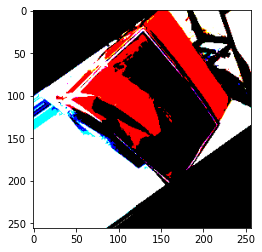

In [27]:
plt.imshow(x_augmented[7])

In [19]:
plt.imshow(x_datasets[3241])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd5c3d500e0> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

> #### 분류기 전이학습 with Augmentation and Fine-Tuning

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (256,256 ,3), weights = 'imagenet')
base_model.trainable = False

y_datasets = tf.keras.utils.to_categorical(y_datasets, 4)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
)
# datagen.fit(x_datasets)

In [ ]:
model.fit(datagen.flow(x_datasets, y_datasets, batch_size=32, subset='training'), 
    validation_data=datagen.flow(x_datasets, y_datasets, batch_size=32, subset='validation'),
    steps_per_epoch=len(x_datasets) / 40, epochs = 5, callbacks=[early])

Epoch 1/5
101/101 [==============================] - 65s 532ms/step - loss: 7.5158 - accuracy: 0.5805 - val_loss: 0.6730 - val_accuracy: 0.7716
Epoch 2/5
101/101 [==============================] - 52s 518ms/step - loss: 0.7614 - accuracy: 0.6524 - val_loss: 0.3318 - val_accuracy: 0.8679
Epoch 3/5
101/101 [==============================] - 52s 513ms/step - loss: 0.7271 - accuracy: 0.6943 - val_loss: 0.4388 - val_accuracy: 0.9173
Epoch 4/5
101/101 [==============================] - 51s 504ms/step - loss: 0.6818 - accuracy: 0.7184 - val_loss: 0.3480 - val_accuracy: 0.9025
Epoch 5/5
101/101 [==============================] - 51s 502ms/step - loss: 0.6630 - accuracy: 0.7181 - val_loss: 0.5125 - val_accuracy: 0.7889


In [ ]:
## fine-tune
base_model.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

model.fit(datagen.flow(x_datasets, y_datasets, batch_size=32, subset='training'), 
    validation_data=datagen.flow(x_datasets, y_datasets, batch_size=8, subset='validation'),
    steps_per_epoch=len(x_datasets) / 32, epochs = 5, callbacks=[early])

Epoch 1/5
101/101 [==============================] - 62s 540ms/step - loss: 0.8048 - accuracy: 0.6712 - val_loss: 0.2300 - val_accuracy: 0.9420
Epoch 2/5
101/101 [==============================] - 56s 546ms/step - loss: 0.6444 - accuracy: 0.7483 - val_loss: 0.2437 - val_accuracy: 0.9185
Epoch 3/5
101/101 [==============================] - 54s 529ms/step - loss: 0.5323 - accuracy: 0.8001 - val_loss: 0.2770 - val_accuracy: 0.9136
Epoch 4/5
101/101 [==============================] - 54s 531ms/step - loss: 0.4165 - accuracy: 0.8479 - val_loss: 0.1323 - val_accuracy: 0.9568
Epoch 5/5
101/101 [==============================] - 54s 534ms/step - loss: 0.3955 - accuracy: 0.8624 - val_loss: 0.0033 - val_accuracy: 0.9988


In [ ]:
model.evaluate()

In [ ]:
model.save('분류기 전이학습 aug 미세조정')

INFO:tensorflow:Assets written to: 분류기 전이학습 aug 미세조정/assets
